# Fine Tune FaceNet
In this notebook, we are going to fine-tune the FaceNet model so it will specialize in encoding the known faces and separate them from the unknown faces

## Load Packages

In [1]:
from os import listdir
import pathlib

import tensorflow as tf
from tensorflow.keras.models import load_model as tf_load_model
import numpy as np
import matplotlib.pyplot as plt

from src.encoders.inception_resnet_v1 import *

Using TensorFlow backend.


## Fine-Tune FaceNet

In [2]:
# load the keras facenet model
face_net_model = tf_load_model('src/encoders/facenet_keras.h5')

## Unfreeze First Two Layers

In [3]:
face_net_model.trainable = True
fine_tune_last = 2
for layer in face_net_model.layers[:-fine_tune_last]:
    layer.trainable = False
# look at the summary
face_net_model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

Block35_5_Branch_1_Conv2d_0b_3x (None, 17, 17, 32)   9216        Block35_5_Branch_1_Conv2d_0a_1x1_
__________________________________________________________________________________________________
Block35_5_Branch_2_Conv2d_0c_3x (None, 17, 17, 32)   9216        Block35_5_Branch_2_Conv2d_0b_3x3_
__________________________________________________________________________________________________
Block35_5_Branch_0_Conv2d_1x1_B (None, 17, 17, 32)   96          Block35_5_Branch_0_Conv2d_1x1[0][
__________________________________________________________________________________________________
Block35_5_Branch_1_Conv2d_0b_3x (None, 17, 17, 32)   96          Block35_5_Branch_1_Conv2d_0b_3x3[
__________________________________________________________________________________________________
Block35_5_Branch_2_Conv2d_0c_3x (None, 17, 17, 32)   96          Block35_5_Branch_2_Conv2d_0c_3x3[
__________________________________________________________________________________________________
Block35_5_

Block17_9_Branch_1_Conv2d_0a_1x (None, 8, 8, 128)    0           Block17_9_Branch_1_Conv2d_0a_1x1_
__________________________________________________________________________________________________
Block17_9_Branch_1_Conv2d_0b_1x (None, 8, 8, 128)    114688      Block17_9_Branch_1_Conv2d_0a_1x1_
__________________________________________________________________________________________________
Block17_9_Branch_1_Conv2d_0b_1x (None, 8, 8, 128)    384         Block17_9_Branch_1_Conv2d_0b_1x7[
__________________________________________________________________________________________________
Block17_9_Branch_1_Conv2d_0b_1x (None, 8, 8, 128)    0           Block17_9_Branch_1_Conv2d_0b_1x7_
__________________________________________________________________________________________________
Block17_9_Branch_0_Conv2d_1x1 ( (None, 8, 8, 128)    114688      Block17_8_Activation[0][0]       
__________________________________________________________________________________________________
Block17_9_

Total params: 22,808,144
Trainable params: 229,504
Non-trainable params: 22,578,640
__________________________________________________________________________________________________


## Set Up Data Pipleline

In [4]:
data_dir = 'data/faces/train/'
data_dir = pathlib.Path(data_dir)

In [5]:
IMAGE_SHAPE = (160,160)
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    validation_split=0.15)

train_ds = train_image_generator.flow_from_directory(
    str(data_dir),
    target_size=IMAGE_SHAPE,
    subset="training",
    batch_size=10)

val_ds = train_image_generator.flow_from_directory(
    str(data_dir), 
    target_size=IMAGE_SHAPE,
    subset="validation",
    batch_size=10)

Found 610 images belonging to 3 classes.
Found 105 images belonging to 3 classes.


## Add a Classification Head and Train

We will add a simple classifier head and use crossentropy loss to fine-tune the model

In [8]:
CLASS_COUNT = len(listdir(data_dir))
model = tf.keras.Sequential([
  face_net_model,
  tf.keras.layers.Dense(CLASS_COUNT)
])

In [9]:
# look at model summary to make sure everything is as expected
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v1 (Model)  (None, 128)               22808144  
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 22,808,531
Trainable params: 229,891
Non-trainable params: 22,578,640
_________________________________________________________________


In [10]:
# compile model
model.compile(
  # set a low learning rate so we don't overfit too quickly
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [11]:
# set some call back functions to collect batch-level information
# class CollectBatchStats(tf.keras.callbacks.Callback):
#   def __init__(self):
#     self.batch_losses = []
#     self.batch_acc = []

#   def on_train_batch_end(self, batch, logs=None):
#     self.batch_losses.append(logs['loss'])
#     self.batch_acc.append(logs['acc'])
#     self.model.reset_metrics()

In [12]:
# start training
steps_per_epoch = np.ceil(train_ds.samples/train_ds.batch_size)
# batch_stats_callback = CollectBatchStats()
history = model.fit(train_ds, 
                    epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds,
                    callbacks=[
                        # save the best performing model
                        tf.keras.callbacks.ModelCheckpoint(
                            filepath='tuned-model.h5',
                            save_best_only=True)])

Train for 61.0 steps, validate for 11 steps
Epoch 1/10
61/61 [==============================] - 138s 2s/step - loss: 0.4394 - acc: 0.8426 - val_loss: 0.7073 - val_acc: 0.7905
Epoch 2/10
61/61 [==============================] - 32s 525ms/step - loss: 0.1650 - acc: 0.9590 - val_loss: 0.5994 - val_acc: 0.8190
Epoch 3/10
61/61 [==============================] - 29s 476ms/step - loss: 0.0926 - acc: 0.9738 - val_loss: 0.5027 - val_acc: 0.8667
Epoch 4/10
61/61 [==============================] - 30s 498ms/step - loss: 0.0562 - acc: 0.9902 - val_loss: 0.4279 - val_acc: 0.8762
Epoch 5/10
61/61 [==============================] - 26s 433ms/step - loss: 0.0342 - acc: 0.9951 - val_loss: 0.4287 - val_acc: 0.8952
Epoch 6/10
61/61 [==============================] - 28s 454ms/step - loss: 0.0241 - acc: 0.9984 - val_loss: 0.4115 - val_acc: 0.8952
Epoch 7/10
61/61 [==============================] - 25s 405ms/step - loss: 0.0157 - acc: 1.0000 - val_loss: 0.4162 - val_acc: 0.8857
Epoch 8/10
61/61 [=========

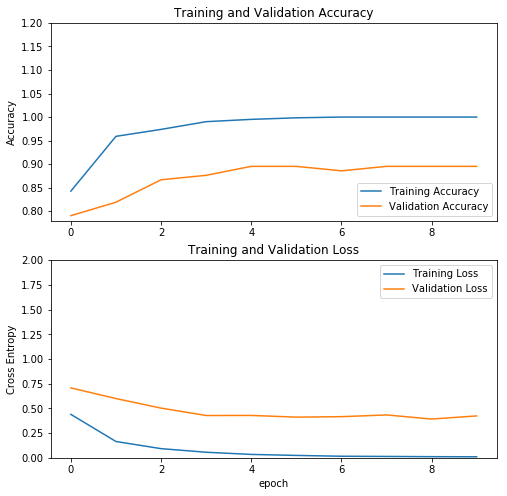

In [13]:
# look at the training and validation graph just for fun
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.2])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Strip the Classification Head

In this section, we will strip the classification head and save the the FaceNet encoder as a lone model, so we can use it the same way as the original one.

In [15]:
# load the tuned model with classification head
trained_model = tf_load_model('tuned-model.h5')

For unkown reasons, keras models run faster in inferene time than a tf.keras model. Therefore, we will save the tf.keras model back to a keras model.

In [17]:
# strip the head and save as keras model

# create a inception v1 model in keras
model = InceptionResNetV1()
# transfer weights over
model.set_weights(trained_model.layers[0].get_weights())

In [18]:
# save model
model.save("src/encoders/tuned_facenet_keras_2.h5")